# 20 - Plug-and-Play Estimators

## Problem Setup

- CATE:

$$\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]$$

- 이전 챕터에서 CATE를 interaction($X,t$)이 있는 linear regression 모델로 구했다.

$$y_i = \beta_0 + \beta_1 t_i + \beta_2 X_i + \beta_3 t_i X_i + e_i.$$

$$\hat{\tau}(x) = \hat{\beta}_1 + \hat{\beta}_3 X_i$$

- 하지만 이는 한계점이 있다.
  - outcome과 linear relationship이여야 한다.
- 그래서 linear가 아닌 좀 더 complex한 ML 모델을 사용하고 싶다.
- 하지만 ML 모델로는 outcome만 예측할 수 있고 $\hat{\tau(x)}$는 알 수 없다.

## Target Transformation

- treatment가 binary라고 가정하자.
- financial education email의 효과에 대해 확인하고 싶다.
    - email이 사람들로 하여금 더 투자하게 만든다.
- random하게 50%는 보내고 50%는 보내지 않았다.

$$T \perp Y(1), Y(0)$$

- 먼저 outcome variable을 바꿔보자.

$$Y^*_i = 2 Y_i * T_i - 2 Y_i*(1-T_i)$$

- $Y_i*T_i = Y(1)_i*T_i$
- $Y_i*(1-T_i) = Y(0)_i*T_i$

$$\begin{align}
E[Y^*_i|X_i=x] &= E[2 Y(1)_i * T_i - 2 Y(0)_i*(1-T_i)|X_i=x] \\
&= 2E[Y(1)_i * T_i | X_i=x] - 2E[Y(0)_i*(1-T_i)|X_i=x]\\
&= 2E[Y(1)_i| X_i=x] * E[ T_i | X_i=x] - 2E[Y(0)_i| X_i=x]*E[(1-T_i)|X_i=x] \\
&= 2E[Y(1)_i| X_i=x] * 0.5 - 2E[Y(0)_i| X_i=x]*0.5 \\ 
&= E[Y(1)_i| X_i=x] - E[Y(0)_i| X_i=x] \\
&= \tau(x)_i
\end{align}$$

- 위의 과정을 통해서 unbiased estimate of the individual treatment effect $\tau(x)_i$를 구할 수 있다.

- 그렇다면 이제는 일반화해보자.
  - random이 아닌 경우라면?
  - 50%, 50%이 아니라면?
- conditional independence와 propensity score를 이용한다.
  - $T \perp Y(1), Y(0)|X$
  - $e(X_i)$: propensity score

$$Y^*_i = Y_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}$$

$$\begin{align}
E[Y^*_i|X_i=x] &= E\big[Y_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big] \\
&= E\big[Y_i T_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))} + Y_i (1-T_i) * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big]\\
&= E\big[Y(1)_i * \dfrac{T_i(1 - e(X_i))}{e(X_i)(1-e(X_i))} | X_i=x\big] - E\big[Y(0)_i * \dfrac{(1-T_i)e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big]\\
&= \dfrac{1}{e(X_i)} E[Y(1)_i * T_i|X_i=x] - \dfrac{1}{1-e(X_i)} E[Y(0)_i * (1-T_i)| X_i=x]\\
&= \dfrac{1}{e(X_i)} E[Y(1)_i|X_i=x] * E[T_i|X_i=x] - \dfrac{1}{1-e(X_i)} E[Y(0)_i|X_i=x] * E[(1-T_i)| X_i=x]\\
&= E[Y(1)_i|X_i=x] - E[Y(0)_i|X_i=x]\\
&= \tau(x)_i
\end{align}$$

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# from nb21 import cumulative_gain, elast

In [14]:
email = pd.read_csv("./data/invest_email_rnd.csv")
email.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,1,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,1,0,1,1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0
4,35.3,2787.26,27074.44,14114.86,1,1,1,0


$$E[Converted(1)_i - Converted(0)_i|X_i=x] = \tau(x)_i$$

In [15]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
train, test = train_test_split(email, test_size=0.4)
print(train.shape, test.shape)

(9000, 8) (6000, 8)


- target값을 바꿔준다.

In [16]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

ps = train[T].mean()  # ps

y_star_train = train[y] * (train[T] - ps)/(ps*(1-ps))

In [17]:
from lightgbm import LGBMRegressor

np.random.seed(123)
cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)
cate_learner.fit(train[X], y_star_train);

In [18]:
test_pred = test.assign(cate=cate_learner.predict(test[X]))
test_pred.head()

,age,income,insurance,invested,em1,em2,em3,converted,cate
6958,40.9,4486.14,37320.33,12559.25,0,0,1,0,0.105665
7534,42.6,6386.19,13270.47,29114.42,0,0,1,0,0.121922
2975,47.6,1900.26,25588.72,2420.39,0,0,1,0,0.034161
3903,41.0,5802.19,57087.37,20182.20,1,0,1,1,0.046805
8437,49.1,2202.96,5050.81,9245.88,1,0,1,0,-0.009099


In [32]:
def elast(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([elast(ordered_df[:rows], y, t) * (rows/size) for rows in n_rows])

- cumulative gain의 결과는 아래와 같다.
- train에 overfitting된 것 같다.

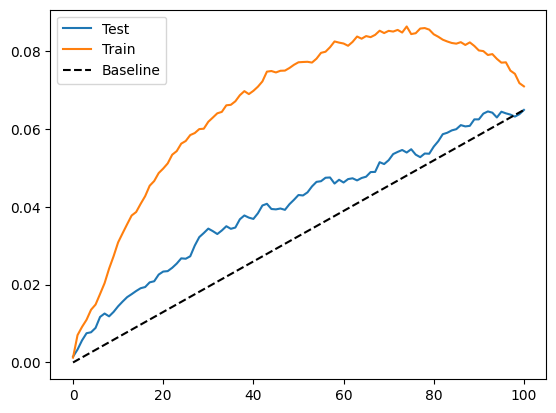

In [36]:
gain_curve_test = cumulative_gain(test_pred, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[X])), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();

## The Continuous Treatment Case

- 하지만 위와 같은 target transformation은 binary treatment의 경우에 해당한다.
- treatment가 continous의 경우에는 모두 treatment를 받았다고 할 수 있지만 그 정도가 다른 것이다.
- 따라서 위에서한 방법과는 약간 다르게 접근해 볼 수 있다.
- treatment의 변화량에 따라 target이 얼마나 변하는지: 기울기
    - treatment와 target이 linear한 관계를 가지는 것을 상상해보자

$$\tau(x) = E[\partial Y_i(t)|X] = E[\tau_i|X]$$

$$\hat{\tau(x)} = Cov(Y_i, T_i)/Var(T_i) = \dfrac{\sum(Y_i- \bar{Y})(T_i - \bar{T})}{\sum (T_i - \bar{T})^2}$$

$$Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - \bar{T})}{\sigma^2_T}$$

- under random assignment
- $V_i = \dfrac{(T_i - \bar{T})}{\sigma^2_T}$
- $Y_i = \alpha + \beta T_i + e_i | X_i=x$
- $E[V_i|X_i=x]=0$
- $E[T_i V_i | X_i=x]=1$

$$\begin{align}
E[Y^*_i|X_i=X] &= E[(Y_i-\bar{Y})V_i | X_i=x] \\
&= E[(\alpha + \beta T_i + e_i - \bar{Y})V_i | X_i=x] \\
&= \alpha E[V_i | X_i=x] + \beta E[T_i V_i | X_i=x] + E[e_i V_i | X_i=x] \\
&= \beta + E[e_i V_i | X_i=x] \\
&= \beta = \tau(x)
\end{align}$$


- for non randomized treatment
    - replace $\bar{T}$ by $M(X_i)$
    - $M(X_i)=E[T_i|X_i=x]$

$$Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - M(T_i))}{\Sigma(T_i - M(T_i))^2}$$

- 그런데 우리는 상대적인 크기만 중요하기 때문에 분모를 제외하면

$$Y^*_i = (Y_i- \bar{Y})(T_i - M(T_i))$$



In [37]:
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")
prices_rnd.head()

,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


In [38]:
np.random.seed(123)
train, test = train_test_split(prices_rnd, test_size=0.3)
train.shape, test.shape

((3500, 5), (1500, 5))

In [39]:
y_star_cont = (train["price"] - train["price"].mean()
               *train["sales"] - train["sales"].mean())

In [40]:
cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)

np.random.seed(123)
cate_learner.fit(train[["temp", "weekday", "cost"]], y_star_cont)

cate_test_transf_y = cate_learner.predict(test[["temp", "weekday", "cost"]])

test_pred = test.assign(cate=cate_test_transf_y)
test_pred.sample(5)

,temp,weekday,cost,price,sales,cate
2815,15.7,4,1.5,3,187,-1395.956278
257,29.4,3,1.0,3,209,-1607.400415
2585,24.6,6,1.0,10,197,-1497.197402
3260,20.2,1,0.5,4,246,-1629.798111
1999,10.0,4,0.5,10,139,-1333.690544


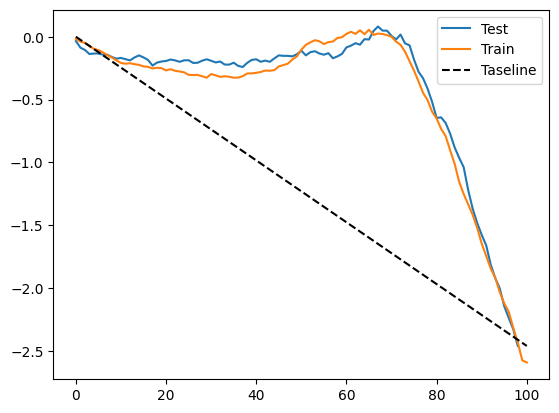

In [41]:
gain_curve_test = cumulative_gain(test.assign(cate=cate_test_transf_y),
                                "cate", y="sales", t="price")

gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[["temp", "weekday", "cost"]])),
                                   "cate", y="sales", t="price")


plt.plot(gain_curve_test, label="Test")
plt.plot(gain_curve_train, label="Train")
plt.plot([0, 100], [0, elast(test, "sales", "price")], linestyle="--", color="black", label="Taseline")
plt.legend();